# Step 1: Prep and Data Exploration

In [1]:
# import all libraries required to load, transform, analyze and plot
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox

import scipy.stats as stats

# set display option to remove scientific notation and 
# remove restrictions on dataframe rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)


data = pd.read_csv('data/kc_house_data.csv')

In [2]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Note missing values for waterfront, view, year renovated
# Zipcode is an integer, which is pretty useless as zipcodes do not work 
# numerically. Should be a string or category. 
# "Date" is a datetime object, which cannot be in a model 
# sqfootbasement is an object due to ? in some rows

In [5]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00","19,221.00","21,534.00","21,597.00","21,597.00","21,597.00","21,597.00","17,755.00","21,597.00","21,597.00","21,597.00","21,597.00","21,597.00"
mean,"4,580,474,287.77","540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,0.01,0.23,3.41,7.66,"1,788.60","1,971.00",83.64,"98,077.95",47.56,-122.21,"1,986.62","12,758.28"
std,"2,876,735,715.75","367,368.14",0.93,0.77,918.11,"41,412.64",0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,"27,274.44"
min,"1,000,102.00","78,000.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,175.00","322,000.00",3.00,1.75,"1,430.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00","1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,490.00","645,000.00",4.00,2.50,"2,550.00","10,685.00",2.00,0.00,0.00,4.00,8.00,"2,210.00","1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


In [6]:
# Waterfront is likely not going to be that useful -- very few 1's
# which tells us waterfront is sparsely populated 
# Small percentage of home have been renovated recently given 75th percentile 0.

In [7]:
not_renovated = data.loc[data['yr_renovated'] == 0]
not_renovated.head()
not_renovated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17011 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17011 non-null  int64  
 1   date           17011 non-null  object 
 2   price          17011 non-null  float64
 3   bedrooms       17011 non-null  int64  
 4   bathrooms      17011 non-null  float64
 5   sqft_living    17011 non-null  int64  
 6   sqft_lot       17011 non-null  int64  
 7   floors         17011 non-null  float64
 8   waterfront     15157 non-null  float64
 9   view           16961 non-null  float64
 10  condition      17011 non-null  int64  
 11  grade          17011 non-null  int64  
 12  sqft_above     17011 non-null  int64  
 13  sqft_basement  17011 non-null  object 
 14  yr_built       17011 non-null  int64  
 15  yr_renovated   17011 non-null  float64
 16  zipcode        17011 non-null  int64  
 17  lat            17011 non-null  float64
 18  long  

In [8]:
17011/21597

0.787655692920313

In [9]:
# 78% of entries have 0 as a value in the renovated column, so we should drop this as 
# a predictor probably

In [10]:
# Investigating outliers
data.loc[data['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,"640,000.00",33,1.75,1620,6000,1.00,0.00,0.00,5,7,1040,580.0,1947,0.00,98103,47.69,-122.33,1330,4700


In [11]:
data.loc[data['bathrooms'] == 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800
12764,1225069038,5/5/2014,"2,280,000.00",7,8.00,13540,307752,3.00,0.00,4.00,3,12,9410,4130.0,1999,0.00,98053,47.67,-121.99,4850,217800


In [12]:
data.loc[data['sqft_lot'] == 1651359]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,"700,000.00",4,1.00,1300,1651359,1.00,0.00,3.00,4,6,1300,0.0,1920,0.00,98022,47.23,-122.02,2560,425581


In [13]:
data.loc[data['price'] == 7700000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,"7,700,000.00",6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,"1,987.00",98102,47.63,-122.32,3940,8800


In [14]:
# Bedrooms: One outlier at 33 bedrooms - though only sold for 640k so most likely a data entry error
# Square footage: obvious outlier at 1,651,359. Mean is nearly double median. 
# Sale price: 7.7 million sale price outlier for sale price; mean is higher than median 

In [15]:
#plt.figure(figsize=(10,8))
#sns.heatmap(data.corr().abs(), annot=True)
#plt.show()

In [16]:
# Just eyeballing, sqft_living (.70), grade (.67), sqft_above (.61), sq_ftliving15 (.59) & bathrooms (.53)
# Seem to be particularly strong predictors. 
# Disappointingly bedrooms is not all that strong at .31, but we'll keep it in for now 
# Because it is often a differentiating factor when buying or selling a home

In [17]:
#sns.pairplot(data)

# Step 2: Data Cleaning

In [18]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [19]:
# Dropping some columns that look less promising
# df.drop(['B', 'C'], axis=1, inplace=True) <-- to make the change the df itself , use inplace=True
to_drop = ['id', 'date', 'view', 'sqft_above', 'lat', 'long', 'sqft_lot15', 'sqft_basement', 'waterfront','yr_renovated']

In [20]:
data.drop(to_drop, axis = 1, inplace = True)

In [21]:
data.shape

(21597, 11)

In [22]:
# Drop one really obvious outlier that was clearly a data entry error
mask = data.loc[data['bedrooms']>20].index
data.drop(mask, axis = 0, inplace=True)

In [23]:
data.shape

(21596, 11)

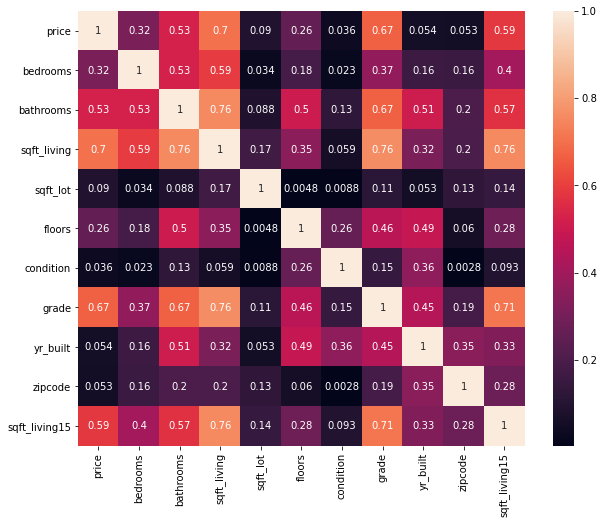

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().abs(), annot=True)
plt.show()

In [25]:
#sns.pairplot(data)

# Step 3: Split Data into Training and Test Sets

In [26]:
# divide dataset into X predictors and y target
X = data.drop(['price'], axis=1)
y = data[['price']]

# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [27]:
len(X_test) + len(X_train) == len(X)

True

In [28]:
X_train.shape

(17276, 10)

In [29]:
X_test.shape

(4320, 10)

In [30]:
# Instantiate a scaler
from sklearn.preprocessing import StandardScaler

In [31]:
scaler = StandardScaler()

In [32]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: First Substandard Model

In [33]:
# Instantiate a linear regression model
lr = LinearRegression()

In [34]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error

In [36]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.6237661706892493
Mean Absolute Error: 144945.57636353228
---
Testing Scores:
R2: 0.6052645946329722
Mean Absolute Error: 145254.48398036984


In [37]:
# Fine, but not great
# Training higher than testing, which is an indication of underfitting 
# MAE = $145,254 indicates average error in predicting a home price, 
# which is almost 2x more than the minimum in the dataset

# Step 5: Visualization/Iteration

In [ ]:
# iterating basically means brainstorming 
# don't only look at r-squared for one and then only look at root mean squared, etc. 
# check test data to make sure it matches the bounds that you expect 


Stacked bar charts to visualize distribution of prices 
https://hackernoon.com/predicting-the-price-of-houses-in-brooklyn-using-python-1abd7997083b

## Iteration 1 - Zip Codes

##### Doing some data prep work in order to visualize median price per zip code.

In [38]:
traindf = X_train.copy()

In [39]:
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550


In [40]:
traindf['price'] = y_train
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300,"332,500.00"
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310,"390,000.00"
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200,"800,000.00"
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760,"462,000.00"
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550,"695,000.00"


In [41]:
traindf.shape

(17276, 11)

In [42]:
traindf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
6243,4,2.00,1440,4855,2.00,4,7,1972,98144,1300,"332,500.00"
8986,3,1.75,1430,9857,1.00,4,7,1980,98045,1310,"390,000.00"
9419,4,2.75,3120,5000,2.00,3,9,2010,98074,3200,"800,000.00"
10155,4,2.50,2060,6958,1.00,3,7,1974,98034,1760,"462,000.00"
10436,3,2.00,2500,4080,1.50,5,7,1922,98103,1550,"695,000.00"


In [43]:
testdf = X_test.copy()

In [44]:
testdf['price'] = y_test

In [45]:
testdf.shape

(4320, 11)

In [46]:
testdf.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,sqft_living15,price
3686,3,0.75,850,8573,1.00,3,6,1945,98146,850,"132,500.00"
10247,3,1.00,1510,6083,1.00,4,6,1940,98115,1510,"415,000.00"
4037,4,2.25,1790,42000,1.00,3,7,1983,98045,2060,"494,000.00"
3437,2,1.50,1140,2500,1.00,3,7,1988,98106,1500,"355,000.00"
19291,3,1.00,1500,3920,1.00,3,7,1947,98107,1640,"606,000.00"


In [47]:
# Replace all values in zipcode column with median sale price 
# 1. Group all zipcodes together with median average sale price 
# 2. Replace any zipcode value corresponding to a particular zip code with its median average sales price 

In [48]:
zip_group = traindf.groupby(['zipcode']).median()

In [49]:
test_zip_group = testdf.groupby(['zipcode']).median()

In [50]:
zip_group.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price
zipcode,,,,,,,,,,
98001,3.00,2.12,"1,875.00","9,303.50",1.00,3.00,7.00,"1,981.00","1,710.00","264,750.00"
98002,3.00,1.75,"1,575.00","7,279.00",1.00,4.00,7.00,"1,967.00","1,420.00","235,000.00"
98003,3.00,2.00,"1,730.00","8,900.00",1.00,3.00,7.00,"1,975.00","1,755.00","265,000.00"
98004,4.00,2.50,"2,620.00","11,125.00",1.00,3.00,8.00,"1,964.00","2,510.00","1,100,000.00"
98005,4.00,2.25,"2,500.00","12,815.50",1.00,4.00,8.00,"1,967.00","2,490.00","779,000.00"


In [51]:
test_zip_group.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price
zipcode,,,,,,,,,,
98001,3.00,2.00,"1,620.00","9,135.00",1.00,3.00,7.00,"1,984.00","1,610.00","246,900.00"
98002,3.00,2.00,"1,550.00","7,314.00",1.00,4.00,7.00,"1,961.00","1,340.00","235,000.00"
98003,3.00,2.25,"2,020.00","8,620.00",1.00,3.00,7.00,"1,977.00","1,840.00","271,500.00"
98004,4.00,2.50,"2,920.00","10,929.00",1.50,3.00,9.00,"1,966.00","2,600.00","1,430,000.00"
98005,4.00,2.50,"2,605.00","10,769.50",1.00,4.00,8.00,"1,967.50","2,260.00","742,250.00"


In [52]:
zip_group.shape

(70, 10)

In [53]:
zip_group = zip_group['price'].reset_index()

In [54]:
zip_group.head()

,zipcode,price
0,98001,"264,750.00"
1,98002,"235,000.00"
2,98003,"265,000.00"
3,98004,"1,100,000.00"
4,98005,"779,000.00"


In [55]:
# Join zip_group with train df
joined_zip = pd.merge(zip_group, traindf, how = 'inner', on='zipcode').reset_index()
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [56]:
# Join zip_group with test df 
joined_test_zip = pd.merge(zip_group, testdf, how='inner', on='zipcode').reset_index()
joined_test_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [57]:
joined_test_zip.shape

(4320, 13)

In [58]:
# Compare to one hot encoded zip code 

# Distance from the home. Lat-long - is that meaningful? 

# Find lat-long centerpoint of each zip code and use that instead 

##### Visualizing median price per zip code.

In [ ]:
import folium

In [ ]:
Seattle_map = folium.Map(location = [47.608013,-122.335167], zoom_start = 10)

In [ ]:
# Visualize relationship between zip code and median house price 
zipcodes_json = folium.GeoJson("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson", name="geojson").add_to(Seattle_map)
folium.LayerControl().add_to(Seattle_map)

Seattle_map.save("index.html")
Seattle_map

In [ ]:
folium.Choropleth(
    geo_data=zipcodes_json, 
    data = zip_group,
    columns=['zipcode','price'],
    key_on='feature.properties.ZIP',
    fill_color='Blues',
    nan_fill_color='gray',
).add_to(Seattle_map)

folium.LayerControl().add_to(Seattle_map)

##### Adding median-price-per-zip-code feature to model. 

In [59]:
# Joined_zip is the training data for iteration 2
joined_zip.shape

(17276, 13)

In [60]:
joined_zip.head()

,index,zipcode,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [61]:
# Rename price_x column as median price per zipcode 
joined_zip = joined_zip.rename(columns={"price_x": "med_price_for_zip"})
joined_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,1,98001,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,2,98001,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,3,98001,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,4,98001,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [62]:
# Drop zipcode and index columns
trained_zip = joined_zip.drop(['index', 'zipcode'], axis=1)
trained_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",2,1.75,1220,15600,1.00,3,6,1972,1510,"215,500.00"
1,"264,750.00",4,2.50,2400,4596,2.00,3,8,2004,2230,"280,000.00"
2,"264,750.00",5,1.75,1950,8720,1.00,3,7,1962,1660,"274,000.00"
3,"264,750.00",3,1.00,1390,16000,1.00,4,6,1960,1420,"230,000.00"
4,"264,750.00",4,1.75,1790,12000,1.00,5,6,1944,1550,"199,900.00"


In [64]:
# Do the same with test data
test_zip = joined_test_zip.rename(columns={"price_x": "med_price_for_zip"})
test_zip.head()

,index,zipcode,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,0,98001,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,1,98001,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,2,98001,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,3,98001,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,4,98001,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [65]:
test_zip = joined_test_zip.drop(['index', 'zipcode'], axis=1)
test_zip.head()

,med_price_for_zip,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,price_y
0,"264,750.00",3,1.75,2170,10018,1.00,4,7,1978,2049,"260,000.00"
1,"264,750.00",3,1.00,1150,6480,1.50,4,5,1946,1100,"171,500.00"
2,"264,750.00",3,2.00,1050,18304,1.00,4,7,1953,1690,"250,000.00"
3,"264,750.00",5,2.50,2406,7093,2.00,3,8,2006,1767,"270,500.00"
4,"264,750.00",3,2.25,1830,11331,1.00,3,7,1965,2240,"230,000.00"


In [67]:
# Divide data in to x predictors and y targets 
# divide dataset into X predictors and y target
X_test_zip = test_zip.drop(['price_y'], axis=1)
y_test_zip = test_zip[['price_y']]

X_trained_zip = trained_zip.drop(['price_y'], axis=1)
y_trained_zip = trained_zip[['price_y']]

In [68]:
# Train our scaler on training data, then fit to testing
X_trained_zip_scaled = scaler.fit_transform(X_trained_zip)
X_test_zip_scaled = scaler.transform(X_test_zip)

In [69]:
# Fit our model on our scaled data
lr.fit(X_trained_zip_scaled, y_trained_zip)

LinearRegression()

In [71]:
# Evaluate
y_train_pred = lr.predict(X_trained_zip_scaled)
y_test_pred = lr.predict(X_test_zip_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_trained_zip, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_trained_zip, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test_zip, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_zip, y_test_pred)}")

Training Scores:
R2: 0.7363291865117058
Mean Absolute Error: 112465.36617955659
---
Testing Scores:
R2: 0.7229711101210686
Mean Absolute Error: 111841.20169660255


In [72]:
# A little better than our FSM
# Testing now higher than training, which is an indication of overfitting 
# MAE went down slightly which is a good sign